# Project: Dynamic Hedging to Compensate for Price Fluctuations
[Delta hedging](https://en.wikipedia.org/wiki/Delta_neutral) is a strategy used in options trading to minimize the risk associated with price movements in the underlying asset. This approach involves using other options contracts or shares of the underlying asset to achieve a delta-neutral position, i.e., eliminating or mitigating the position's directional bias.
* __Scenario__: Now, put yourself in the shoes of a trader. You've purchased a `TSLA` put option and are now short the shares. You're concerned about how the price movement of `TSLA` shares could affect your options position. This is where you need to take action and construct a delta-neutral hedge to manage this risk.

From the buyer's perspective, purchasing a put option indicates that the buyer believes that TSLA shares will decline in price, i.e., the buyer is `bearish` on TSLA. Let's explore how delta-neutral hedging would work for a long put.

## Learning objectives
Similar to the example, this project will ask students to compute a hedged position on a `TSLA` put option. It assumes perfect information and no market friction, i.e., no problems with buying or selling the `TSLA` shares and no transaction costs. 

__How is this project from the example?__ This project is similar to the example provided in this module, with the difference being that you will use [the Greeks](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw) to calculate the change in the put option premium, instead of using the [full binomial lattice model](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#Binomial-pricing-model). Therefore, you will need to update [the Greek values](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw), as well as your estimates of the share price and volatility, at each trading period.

* __Task 1__: Load simulation data from the worked example. Before simulating the hedge on the `TSLA` put option, we load the simulation state file generated in the worked example and use the data to set constants and throughout the project.
    * `TODO`: Sample Discrete Binomial Equity Tree of Future Share Prices
    * `TODO`: Sample Synthetic Future Implied Volatility Trajectories
* __Task 2__: Construct a dynamically hedged position on a `TSLA` put. In this task, we'll dynamically compute the number of shares in the hedged position that are required to exactly maintain the value of the position, where the change in premium is calculated using the Greeks
    * `TODO`: Build a `TSLA` put contract model
    * `TODO`: Simulate a Dynamic Equity Hedge assuming perfect information and no market friction, where [the Greeks](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw) are used to compute the put option premium.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl")

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-12/L12b/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-12/L12b/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-12/L12b`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-12/L12b/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-12/L12b/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepository-Fall-2024/lectures/week-12/L12b/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-CourseRepos

## Task 1: Load simulation data from the worked example
Before setting up the hedge on the `TSLA` put option, let's load the simulation state file we generated in the worked example. To load the state file, we will use [the `load(...)` method exported by the JLD2.jl package](https://github.com/JuliaIO/JLD2.jl), and we will provide the path to the save file as an argument in the `path_to_save_file::String` variable:

In [5]:
path_to_save_file = joinpath(_PATH_TO_DATA, "CHEME-5660-L12b-WorkedExample-State-Fall-2024.jld2");

Then, use [`load(...)` method](https://github.com/JuliaIO/JLD2.jl) to load the file and return a dictionary with the keys specified in the worked example; we save this dictionary in the `my_simulation_dict::Dict{String, Any}` variable:

In [7]:
my_simulation_dict = load(path_to_save_file)

Dict{String, Any} with 14 entries:
  "risk_free_rate"                   => 0.0431
  "T"                                => 0.165753
  "number_of_samples"                => 1000
  "h"                                => 366
  "DTE"                              => 60.5
  "samples_share_price"              => [261.49 261.49 … 261.49 261.49; 261.287…
  "sample_synthetic_index"           => 13
  "samples_IV"                       => [0.605621 0.605621 … 0.605621 0.605621;…
  "perfect_hedge_simulation_example" => Dict{Int64, NamedTuple}(5=>(shares = 43…
  "Δt"                               => 1.0175e-5
  "example_put_contract"             => Dict{String, Any}("day"=>Dict{String, A…
  "number_of_trading_periods"        => 120
  "put_option_model"                 => MyAmericanPutContractModel(260.0, 1, 0.…
  "β"                                => 2.32

### Constants
Now that we have loaded the save file, we specify values for the constants used in the example by passing the respective keys to the variable `my_simulation_dict::Dict{String, Any}.`
- The variable `DTE::Float64` represents the days to the expiration of the options contracts (measured in days), `Δt::Float64` represents the time step used in the simulations. In this case, we are using 1-minute aggregate data (measured in years). The variable `number_of_trading_periods::Int64` represents the number of trading periods we explore, i.e., the number of minutes that we want to simulate, and `T::Float64` denotes the length of the options contracts (measured in years).
- Next, we retrieve information about `TSLA` and the parameters for the binomial lattice used in the simulation. The variable `β::Float64` represents the beta value for `TSLA`, `h::Int64` represents the number of levels of the pricing tree, the variable `risk_free_rate::Float64` represents the risk-free rate (in this case assumed to be the yield on a 10-year US Treasury Note), the variable `number_of_samples::Int64` specifies the number of samples (alternative futures) we will generate in the simulation, and finally, `sample_synthetic_index::Int64` is a randomly chosen index which specifies which sample we'll use in the simulation.

In [9]:
DTE = my_simulation_dict["DTE"]; # data from mid-day, add a little something something so we recover the midpoint premium (ish) (all parameters fixed)
Δt = my_simulation_dict["Δt"]; # 1-min trading periods
number_of_trading_periods = my_simulation_dict["number_of_trading_periods"]; # How many trading periods will we simulate?
T = my_simulation_dict["T"]; # Duration of trading periods in option years
β = my_simulation_dict["β"]; # TSLA 5y monthly beta value 06-25-24
h = my_simulation_dict["h"]; # 6-points per trading period
risk_free_rate = my_simulation_dict["risk_free_rate"]; # yield 10-year treasury note on 13-Jun-2024
number_of_samples = my_simulation_dict["number_of_samples"]; # number of samples to generate
sample_synthetic_index = my_simulation_dict["sample_synthetic_index"]; # generate random synthetic index to explore (must be <= number_of_samples)

13

### Contracts
We can load the previous contract data by passing in the `example_put_contract` key to the `my_simulation_dict::Dict{String, Any}` variable. We save the contract in the `example_put_contract::Dict{String, Any}` variable:

In [11]:
example_put_contract = my_simulation_dict["example_put_contract"]

Dict{String, Any} with 9 entries:
  "day"                => Dict{String, Any}("change"=>0, "high"=>25.03, "change…
  "details"            => Dict{String, Any}("contract_type"=>"put", "ticker"=>"…
  "last_quote"         => Dict{String, Any}("midpoint"=>23.7, "ask"=>23.8, "tim…
  "last_trade"         => Dict{String, Any}("timeframe"=>"REAL-TIME", "exchange…
  "underlying_asset"   => Dict{String, Any}("timeframe"=>"REAL-TIME", "ticker"=…
  "greeks"             => Dict{String, Any}("theta"=>-0.198501, "gamma"=>0.0063…
  "open_interest"      => 2878
  "implied_volatility" => 0.605621
  "break_even_price"   => 236.3

Finally, we set some data from this contract, in particular, the initial share price in the `Sₒ::Float64` variable and the implied volatility `IVₒ::Float64` variable:

In [13]:
Sₒ = example_put_contract["underlying_asset"]["price"]; # TSLA share price
IVₒ = example_put_contract["implied_volatility"]; # IV for i = 9 put with 60-DTE

### Share price and volatility simulation data
Since we saved the previous share price and volatility simulation data, we can load these data arrays from the `my_simulation_dict::Dict{String, Any}` variable (where we do not have to repeat the simulations and analysis underlying the simulations). First, retrieve the `number_of_trading_periods`$\times$`number_of_paths` array holding possible `TSLA` share price values and save this data in the `samples_share_price::Array{Float64,2}` array:

In [15]:
samples_share_price = my_simulation_dict["samples_share_price"];

#### Visualize an example synthetic price trajectory
`Unhide` the code block below to see how we plotted a simulated `TSLA` volume-weighted average price trajectory corresponding to the randomly generated `sample_synthetic_index` variable
* __Summary__: Given the nature of the binomial lattice model, the early time points are close to the share price used to initialize the tree. However, as time progresses, the share price generally begins to have a larger deviation, which is consistent with future share prices having more uncertainty in this model formulation.  

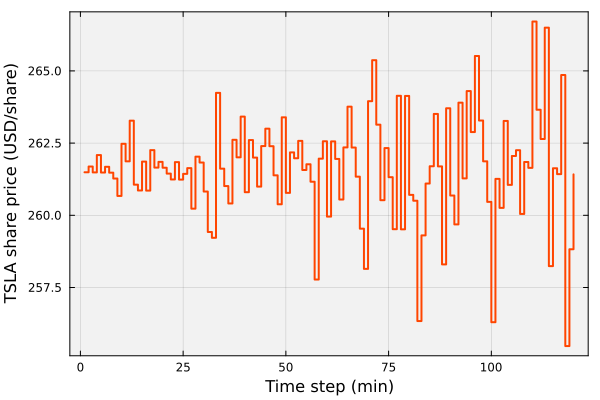

In [17]:
let
    plot(samples_share_price[:,sample_synthetic_index], linetype=:steppost, label="", lw=2, c=:orangered1, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA share price (USD/share)", fontsize=18)
end

Then, retrieve the future implied volatility data from the `my_simulation_dict::Dict{String, Any}` by passing the `samples_IV::String` key to the dictionary. We store the `number_of_trading_periods`$\times$`number_of_samples` volatility array to the  `samples_IV::Array{Float64,2}` variable:

In [19]:
samples_IV = my_simulation_dict["samples_IV"];

#### Visualize implied volatility trajectory
`Unhide` the code block below to view how we generated a plot of the implied volatility for a put option on `TSLA` with `DTE = 60 days` until expiration, where the initial share price is `Sₒ = 261.49 USD per share`. The data shown is for the `sample_synthetic_index` chosen randomly.
* __Summary__: The implied volatility model generates a random sequence of implied volatility over a trading window of length `number_of_trading_periods.` There are some potential issues with this model. For instance, $\sigma_{o}$ and $\sigma_{\sigma}$ may not be stationary, meaning that the average could shift or there could be sudden changes in implied volatility due to external events such as earnings reports or geopolitical events. We ignore these types of events, but more sophisticated models are possible.

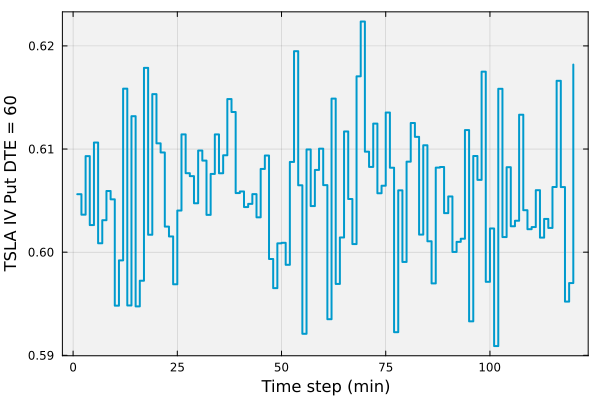

In [21]:
let
    plot(samples_IV[:,sample_synthetic_index], linetype=:steppost, label="", lw=2, c=:deepskyblue3, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Time step (min)", fontsize=18)
    ylabel!("TSLA IV Put DTE = 60", fontsize=18)
end

## Task 2: Construct a dynamically hedged position on a TSLA put using the Greeks
In this task, we'll dynamically compute the number of shares in the hedged position required to maintain the position's value exactly.
A delta-neutral hedge on the long `TSLA` put contract involves buying and selling `TSLA` shares to balance the delta, i.e., the sensitivity of the combined options and equity position to changes in `TSLA` share price. For a hedged position, during the trading period $t\rightarrow{t+dt}$, changes in the options premium are balanced by a gain or loss in the value associated with a counter-asset position (_hedge constraint_ written per contract):
$$
\begin{equation}
100\cdot{d\mathcal{P}} + \mathcal{H} = 0\,\Bigr|_{t\rightarrow{t+dt}}
\end{equation}
$$
where $\mathcal{H}$ denotes the hedge value of the counter asset. Let's equity, e.g., shares of `TSLA` as the counter asset. In this case, we can re-write $\mathcal{H}$ as the difference in the value of an equity position at $t\rightarrow{t+dt}$:
$$
\begin{equation}
\mathcal{H} = n_{t+dt}\cdot{S}_{t+dt} - n_{t}\cdot{S}_{t}
\end{equation}
$$
which we can substitute into the _hedge constraint_ to give the number of shares needed at the end of the interval to offset changes in the options premium during the interval:
$$
\begin{equation}
n_{t+dt} = n_{t}\cdot\left(\frac{S_{t}}{S_{t+dt}}\right) - \frac{100}{S_{t+dt}}\cdot{d\mathcal{P}}
\end{equation}
$$

### Assumptions
Let's make a few assumptions (which we'll revisit later) about the share balance shown above during our initial implementation: 
* __Assumption 1__: We know _exact_ values for the share price $S_{t+dt}$ and the option premium $\mathcal{P}_{t+dt}$ at the end of the interval. This allows us to approximate the change in premium over the interval as $d\mathcal{P}\approx\mathcal{P}_{t+dt} - \mathcal{P}_{t}$, and to compute a value for $n_{t+dt}$.
* __Assumption 2__: There is _no friction_ involving the purchase of the $n_{t+dt}$ shares, i.e., we purchase the shares instantly, our order gets filled at $S_{t+dt}$, and there are no transaction costs associated with purchasing the shares.

These assumptions will enable us to calculate an idealized perfect hedge, which, while not feasible, can be used as a benchmark to assess the performance of any actual implementation.

### TODO: Build a put contract model
To begin, let's build a [MyAmericanPutContractModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) using a [custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}). 
* The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanPutContractModel},%20NamedTuple}) takes two arguments: first, we pass in the type that we want to build, and second we pass data required to initialize the [MyAmericanPutContractModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.MyAmericanPutContractModel) packaged in a [Julia NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple). We store the contract model in the `put_option_model::MyAmericanPutContractModel` variable.

In [24]:
put_option_model = build(MyAmericanPutContractModel, (
    K = example_put_contract["details"]["strike_price"], # random contract
    premium = example_put_contract["last_quote"]["midpoint"], # use last quote midpoint price from the random contract
    DTE = T,
    sense = 1,
    copy = 1,
    IV = example_put_contract["implied_volatility"], # use observed IV value
));

### TODO: Simulate a Dynamic Equity Hedge Assuming Perfect Information using the Greeks
We are ready to simulate the hedge on the `TSLA` put option using a single `for-loop` over the `number_of_trading_periods` minutes. Previously, we used the [full binomial lattice model to estimate the option contract premium]() at the end of the trading interval. Here, use [the Greeks](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw) approximation instead to compute the change in the option premium. We still assume perfect information.

* Initialize the `perfect_hedge_simulation_project::Dict{Int64, NamedTuple}` dictionary to hold the project simulation data, where the keys hold the period index and the values are [Julia NamedTuple instances](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple), and retrieve the `perfect_hedge_simulation_example::Dict{Int64, NamedTuple}` from `my_simulation_dict` (we'll use some data from the example to save on computation). Then, initialize the initial number of shares in the hedge `nₒ::Float64`, the initial option premium value `Pₒ::Float64`, and other setup data.
* For each loop iteration, compute (or access) the data needed to calculate the option premium in period $i$. First, we reduce the duration of the contract by one trading period, i.e., one minute, and store this in the `Tᵢ::Float64` variable. Then we access the new share price `Sᵢ::Float64` and implied volatility `IVᵢ::Float64` from the `samples_share_price` and `samples_IV` arrays.
* Next, we compute the option premium in the interval $i$ using [the Greeks](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw) as opposed to the binomial model used in the worked example. Then, compute the new value for the number of shares `nᵢ::Float64` in the hedge and some other data associated with the trading period using the update rule from above. Store this information in the `perfect_hedge_simulation` dictionary and update the number of shares, premium, and share price for the next interval.
* Update the Greeks [using the `delta(...)`, `theta(...)`, `vega(...)` and the `gamma(...)` functions](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#The-Greeks) using the current market conditions. We ignore the `rho` contribution; thus, we do not calculate it.

In [26]:
# Allocate storage and get data from the worked example
perfect_hedge_simulation_project = Dict{Int64,NamedTuple}();
perfect_hedge_simulation_example = my_simulation_dict["perfect_hedge_simulation_example"];

# initialize -
nₒ = 100*abs(example_put_contract["greeks"]["delta"]); # initial position is delta, we'll update this
Pₒ, P̄ₒ  = put_option_model.premium, put_option_model.premium; # premium
Sₒ = example_put_contract["underlying_asset"]["price"]; # TSLA share price
IVₒ = example_put_contract["implied_volatility"]; # IV for i = 9 put with 60-DTE
Tₒ = put_option_model.DTE; # duration, we'll update this

# get the initial Greeks -
Δₒ = example_put_contract["greeks"]["delta"]; # get the initial delta
Γₒ = example_put_contract["greeks"]["gamma"]; # get the initial gamma
Vₒ = example_put_contract["greeks"]["vega"]; # get the initial vega
Θₒ = example_put_contract["greeks"]["theta"]; # get the initial theta

# main simulation loop -
for i ∈ 1:(number_of_trading_periods - 1)

    # data for this trading period
    Tᵢ = Tₒ - (i)*Δt;
    Sᵢ = samples_share_price[i+1, sample_synthetic_index]; # note: i = 1 is the *current* time point, so i+1 is *next* time
    IVᵢ = samples_IV[i+1, sample_synthetic_index];
    P̄ᵢ = perfect_hedge_simulation_example[i].premium_next; # we'll use this for comparison
    dP̄ᵢ = perfect_hedge_simulation_example[i].premium_actual_delta; # we'll use this for period 1, and then greeks after that

    # TODO: compute the change in the option premium using the Greeks after index 1
    if (i > 1)
        ### BEGIN SOLUTION
        dSᵢ = (Sᵢ - Sₒ);
        dσᵢ = 100*(IVᵢ - IVₒ);
        dTᵢ = (Tᵢ - Tₒ);
        dPᵢ = Δₒ*dSᵢ + (Γₒ/2)*(dSᵢ)^2 + Vₒ*dσᵢ + Θₒ*dTᵢ; # after period 1, compute the premium change using the Greeks
        ### END SOLUTION
    else
        dPᵢ = dP̄ᵢ; # use actual data for the first trading period. (??)
    end
    
    # compute the delta hedge (number of shares we need to be long in the counter asset) for period i -
    nᵢ = nₒ*(Sₒ/Sᵢ) - 100*(dPᵢ)/Sᵢ; # new shares
    residual = (nᵢ*Sᵢ - nₒ*Sₒ) + 100*(dPᵢ); # residual
    LS = (nᵢ*Sᵢ - nₒ*Sₒ); # long share value
    DP = 100*(dPᵢ); # change in premium
    
    # data capture -
    perfect_hedge_simulation_project[i] = (shares = nₒ, shares_next = nᵢ, price = Sₒ, price_next = Sᵢ, IV = IVₒ, IV_next = IVᵢ, premium = Pₒ, 
        premium_next = (Pₒ + dPᵢ), premium_actual_delta = dP̄ᵢ, premium_greek_delta = dPᵢ, hedge = residual, 
        long_shares_diff = LS, long_premium_diff = DP, T = Tᵢ);

    # update -
    nₒ = nᵢ; # update the shares at the start of the next interval
    Pₒ = (Pₒ + dPᵢ); # update the premium at the start of the next interval
    Sₒ = Sᵢ; # update the share price at the start of the next interval
    IVₒ = IVᵢ; # update the implied volatility at the start of the next interval

    # TODO: compute the *updated* Greek values (Δₒ, Θₒ, Vₒ, and Γₒ) with the new market conditions (Sᵢ, Tᵢ, IVᵢ)
    ### BEGIN SOLUTION
    Δₒ = delta(put_option_model, h = h,  T = Tᵢ, 
        σ = IVᵢ, Sₒ = Sᵢ, μ = risk_free_rate);
    Θₒ = theta(put_option_model, h = h,  T = Tᵢ, 
        σ = IVᵢ, Sₒ = Sᵢ, μ = risk_free_rate);
    Vₒ = vega(put_option_model, h = h,  T = Tᵢ, 
        σ = IVᵢ, Sₒ = Sᵢ, μ = risk_free_rate);
    Γₒ = gamma(put_option_model, h = h,  T = Tᵢ, 
        σ = IVᵢ, Sₒ = Sᵢ, μ = risk_free_rate);
    ### END SOLUTION
end

### Visualize the hedge trajectory
`Unihide` the code block below to see how we plotted the $n_{t+dt}$ trajectory for the selected `TSLA` put option for the data from the worked example (retrieved from the `my_simulation_dict::Dict{String, Any}` dictionary) and the current simulation stored in the `perfect_hedge_simulation_project::Dict{Int64, NamedTuple}` dictionary.

#### Summary
* We initialized the simulation with $100\times|\Delta_{p}|$ shares of `TSLA,` i.e., we use the equivalent share meaning of delta to perfectly balance the long and short positions in `TSLA` represented by the long put option (short shares) and the long equity position. As time moves in 1-minute increments, we buy or sell `TSLA` shares to perfectly compensate for changes in the options premium.
* Both cases have similar, but not identical, share trajectories. Due to its approximate nature, we expect that the premium estimation provided by [the Greeks](https://en.wikipedia.org/wiki/en:Greeks_(finance)?variant=zh-tw) leads to potentially broader shifts in the number of `TSLA` shares over the interval (red line) compared to the complete binomial premium calculation from the worked example (dark gray line). This difference increases with the number of intervals due to carry-forward errors.

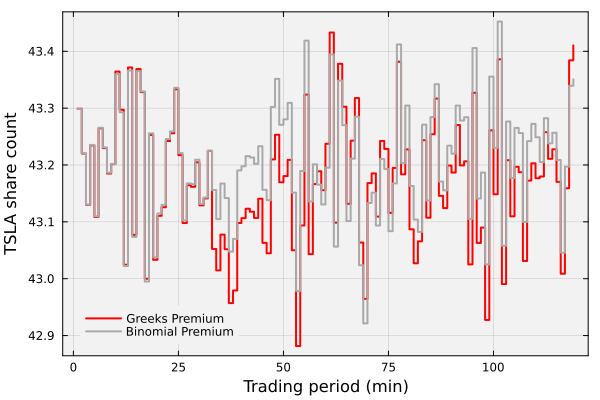

In [28]:
let

    perfect_hedge_simulation_example = my_simulation_dict["perfect_hedge_simulation_example"]; # load previous simulation values
    
    local_data_array = Array{Float64,2}(undef, number_of_trading_periods - 1, 3);
    for i ∈ 1:(number_of_trading_periods - 1)
        local_data_array[i,1] = i;
        local_data_array[i,2] = perfect_hedge_simulation_project[i].shares;
        local_data_array[i,3] = perfect_hedge_simulation_example[i].shares;
    end
    plot(local_data_array[:,1], local_data_array[:,2], linetype=:steppost, label="Greeks Premium", lw=2, c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(local_data_array[:,1], local_data_array[:,3], linetype=:steppost, label="Binomial Premium", lw=2, c=:darkgray, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    xlabel!("Trading period (min)", fontsize=18)
    ylabel!("TSLA share count", fontsize=18)
end

### Build profit, loss, and cost table for the hedged TSLA position
`Unhide` the code block below to see how we constructed a table holding the hedging data computed here, and from the worked example using [a DataFrame](https://github.com/JuliaData/DataFrames.jl) in combination with [the `pretty_tables(...)` function exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl). We show hedging data for the first 20 minutes of the simulation.

#### Summary
* For each period $i$, the change in the options premium ($dP_{i}$) is offset by the hedge value ($H_{i}$). This is achieved by buying or selling `TSLA` shares at $S_{i}$, where $dn_{i}$ represents the change in the number of `TSLA` shares held in the hedge, and $S_{i}\cdot{dn_{i}}$ represents the proceeds (`+`) or costs (`-`) incurred by rebalancing the hedge during the period. The cumulative value of the rebalancing is shown in the `Σ` column. 
* The table also shows the change in premium and hedge rebalancing proceeds (or costs) as well as cumulative proceeds calculated using the binomial model in the example (shown with overbars). As anticipated, the Greek and binomial figures are generally similar but not identical after period `1.` Minor premium differences result in slight changes in rebalancing costs.

In [30]:
let
    
    perfect_hedge_simulation_example = my_simulation_dict["perfect_hedge_simulation_example"]; # load previous simulation values
    n̄, P̄, S̄ = 100*abs(example_put_contract["greeks"]["delta"]), put_option_model.premium, example_put_contract["underlying_asset"]["price"];
    C̄ = (n̄*S̄ + 100*P̄); # cost associated with the position
    
    tmp = DataFrame();
    tmp_cost_sum = Array{Float64,1}();
    tmp_cost_sum_example = Array{Float64,1}();
    
    for i ∈ 1:(number_of_trading_periods - 1)

        data_tuple = perfect_hedge_simulation_project[i];
        data_tuple_example = perfect_hedge_simulation_example[i];
    
        # current -
        nₒ = data_tuple.shares;
        n̄ₒ = data_tuple_example.shares;
        Sₒ = data_tuple.price;
        Pₒ = data_tuple.premium;
        P̄ₒ = data_tuple_example.premium; # from the example
    
        # next -
        nᵢ = data_tuple.shares_next;
        n̄ᵢ = data_tuple_example.shares_next;
        Sᵢ = data_tuple.price_next;
        Pᵢ = data_tuple.premium_next;
        P̄ᵢ = data_tuple_example.premium_next;
    
        # compute H -
        residual = (nᵢ*Sᵢ - nₒ*Sₒ) + 100*(Pᵢ - Pₒ);
        
        # What is the cost of maintaining the hedge?
        dnᵢ = (nᵢ - nₒ); # diff in shares
        Cᵢ = -sign(dnᵢ)*abs(dnᵢ)*Sᵢ
        push!(tmp_cost_sum,Cᵢ);

        # example -
        dn̄ᵢ = (n̄ᵢ - n̄ₒ);
        C̄ᵢ = -sign(dn̄ᵢ)*abs(dn̄ᵢ)*Sᵢ
        push!(tmp_cost_sum_example,C̄ᵢ);
        
        # package -
        row_df = (
            i = (i),
            Hᵢ = (nᵢ*Sᵢ - nₒ*Sₒ),
            dPᵢ = 100*(Pᵢ - Pₒ),
            dP̄ᵢ = 100*(P̄ᵢ - P̄ₒ),
            Sᵢdnᵢ = -Sᵢ*(nᵢ - nₒ),
            Sᵢdn̄ᵢ = -Sᵢ*(n̄ᵢ - n̄ₒ),
            Σ = sum(tmp_cost_sum),
            Σ̄ = sum(tmp_cost_sum_example),
        );
        push!(tmp, row_df)
    end
    pretty_table(tmp[1:20,:])
end

┌───────┬──────────┬──────────┬─────────┬──────────┬──────────┬──────────┬──────────┐
│     i │       Hᵢ │      dPᵢ │     dP̄ᵢ │    Sᵢdnᵢ │    Sᵢdn̄ᵢ │        Σ │        Σ̄ │
│ Int64 │  Float64 │  Float64 │ Float64 │  Float64 │  Float64 │  Float64 │  Float64 │
├───────┼──────────┼──────────┼─────────┼──────────┼──────────┼──────────┼──────────┤
│     1 │   -12.06 │    12.06 │   12.06 │  20.6538 │  20.6538 │  20.6538 │  20.6538 │
│     2 │  -32.376 │   32.376 │   32.24 │  23.5991 │  23.4631 │  44.2529 │  44.1169 │
│     3 │  53.3009 │ -53.3009 │   -53.4 │ -27.4022 │  -27.501 │  16.8507 │  16.6159 │
│     4 │ -59.0269 │  59.0269 │   58.95 │  32.8666 │  32.7892 │  49.7173 │  49.4051 │
│     5 │  49.3547 │ -49.3547 │  -49.29 │ -40.7989 │  -40.734 │  8.91838 │  8.67106 │
│     6 │ -17.9195 │  17.9195 │   17.86 │  9.13382 │  9.07413 │  18.0522 │  17.7452 │
│     7 │ -20.4333 │  20.4333 │   20.36 │  11.6615 │   11.588 │  29.7137 │  29.3332 │
│     8 │ -21.7497 │  21.7497 │   22.05 │ -4.29974 

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.